# Leven at Newby Bridge using HBV model in eWaterCycle

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#general python
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#niceties
from rich import print
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## set up paths

In [3]:
forcing_path = Path.home() / "Forcing"
forcing_path.mkdir(exist_ok=True)

# choose region
We have to pick a region where to run the model, in order to generate forcing inputs for the model. Of course, we choose the region where we are organising this workshop: "Leven at Newby Bridge"

In [4]:
camelsgb_id = "camelsgb_73010"

In [5]:
forcing_path_basin = forcing_path / camelsgb_id 
forcing_path_basin.mkdir(exist_ok=True)

forcing_path_caravan = forcing_path_basin / "caravan"
forcing_path_caravan.mkdir(exist_ok=True)

forcing_path_ERA5 = forcing_path_basin / "ERA5"
forcing_path_ERA5.mkdir(exist_ok=True)

In [6]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"
calibration_start_date = "1997-08-01T00:00:00Z"
calibration_end_date = "2000-08-31T00:00:00Z"


we use camels forcing as an example, which is fully integrated [Newman, 2014](https://gdex.ucar.edu/dataset/camels.html). The seperate text file is hosted [here](https://github.com/Daafip/Msc-Thesis-Notebooks/blob/4735392c4f15af29f433e87491d65668e89663b5/Forcing/01620500_lump_cida_forcing_leap.txt) for easy access without having to download the whole dataset (13gb). 

In [7]:
#two options: generate or load if already generated. Generate again on a location that already contains files will throw an error

# # generate
camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].generate(start_time = experiment_start_date,
                                                               end_time = experiment_end_date,
                                                               directory = forcing_path_caravan,
                                                               basin_id = camelsgb_id,
                                                                 )

# # load
# camelsgb_forcing = ewatercycle.forcing.sources['CaravanForcing'].load(directory = forcing_path_caravan)

In [8]:
print(camelsgb_forcing)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan'),
    shape=PosixPath('/home/rhut/Forcing/camelsgb_73010/caravan/camelsgb_73010.shp'),
    filenames={
        'tasmax': 'camelsgb_73010_1997-08-01_2000-08-31_tasmax.nc',
        'Q': 'camelsgb_73010_1997-08-01_2000-08-31_Q.nc',
        'tasmin': 'camelsgb_73010_1997-08-01_2000-08-31_tasmin.nc',
        'evspsblpot': 'camelsgb_73010_1997-08-01_2000-08-31_evspsblpot.nc',
        'tas': 'camelsgb_73010_1997-08-01_2000-08-31_tas.nc',
        'pr': 'camelsgb_73010_1997-08-01_2000-08-31_pr.nc'
    }
)

<Axes: xlabel='time'>

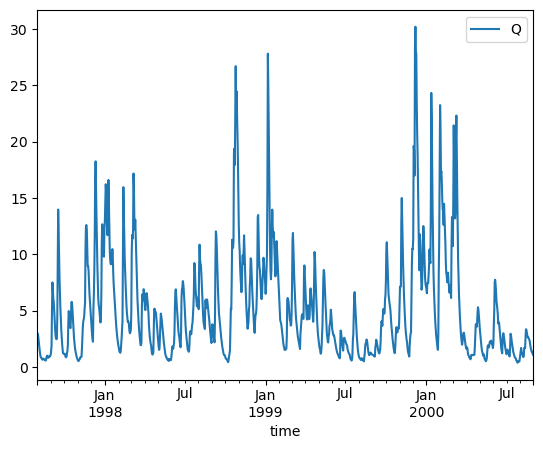

In [9]:
ds = xr.open_dataset(camelsgb_forcing['Q'])
caravan_observation_df = ds['Q'].to_dataframe().reset_index()
caravan_observation_df = caravan_observation_df.set_index('time')
caravan_observation_df = caravan_observation_df[['Q']] #NOTE: mm/day
caravan_observation_df.plot()

In [10]:
ERA5_forcing_dir = forcing_path / camelsgb_id / "ERA5"

In [11]:
#two options: generate or load if already generated. Generate again on a location that already contains files will throw an error

# option one: generate forcing:
ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
   dataset="ERA5",
   start_time=experiment_start_date,
   end_time=experiment_end_date,
   shape=camelsgb_forcing.shape,
   directory=forcing_path_ERA5
)

# #option two: already 
# load_location = forcing_path_ERA5 / "work" / "diagnostic" / "script"
# ERA5_forcing = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

## add parameter info

Array of initial storage terms - we keep these constant for now: <br>
                Si,  Su, Sf, Ss


In [12]:
s_0 = np.array([0,  100,  0,  5, 0])

Array of parameters min/max bounds as a reference: <br>
Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks

In [13]:
#p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
#p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

In [14]:
#The number of ensemble members in our ensemble
N = 1000

## Array of parameters min/max bounds 
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])

#create empty array to fill 
parameters = np.zeros([len(p_min_initial), N])

#fill with random values bounded by the min and max given above.
for param in range(len(p_min_initial)):
    parameters[param,:] = np.random.uniform(p_min_initial[param],p_max_initial[param],N)


Set initial as mean of max,min

In [15]:
par_0 = (p_min_initial + p_max_initial)/2

Specify start and end date

## Forcing

# objective function for calibration

In [16]:
def calibrationObjective(modelOutput,observation,start_calibration,end_calibration):
    # a function that takes in two dataFrames, interpolates the model output to the
    # observations and calculates the average absolute difference between the two.

    #combine the two in one dataFrame
    hydro_data = pd.concat([modelOutput.reindex(observation.index, method = 'ffill'), observation], axis=1)

    #only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    #calculate mean absolute difference

    diff = hydro_data['Q'] - hydro_data['model output']
    rms = np.sqrt(np.mean(diff**2))

    return rms
  

## Setting up the model

IntProgress(value=0, max=1000)

[4.84323561e+00 9.90022888e-01 8.77879673e+01 2.67298356e+00
 2.93155926e-01 1.29446160e+00 8.36216440e-02 5.45953254e-03
 1.68174394e+00]

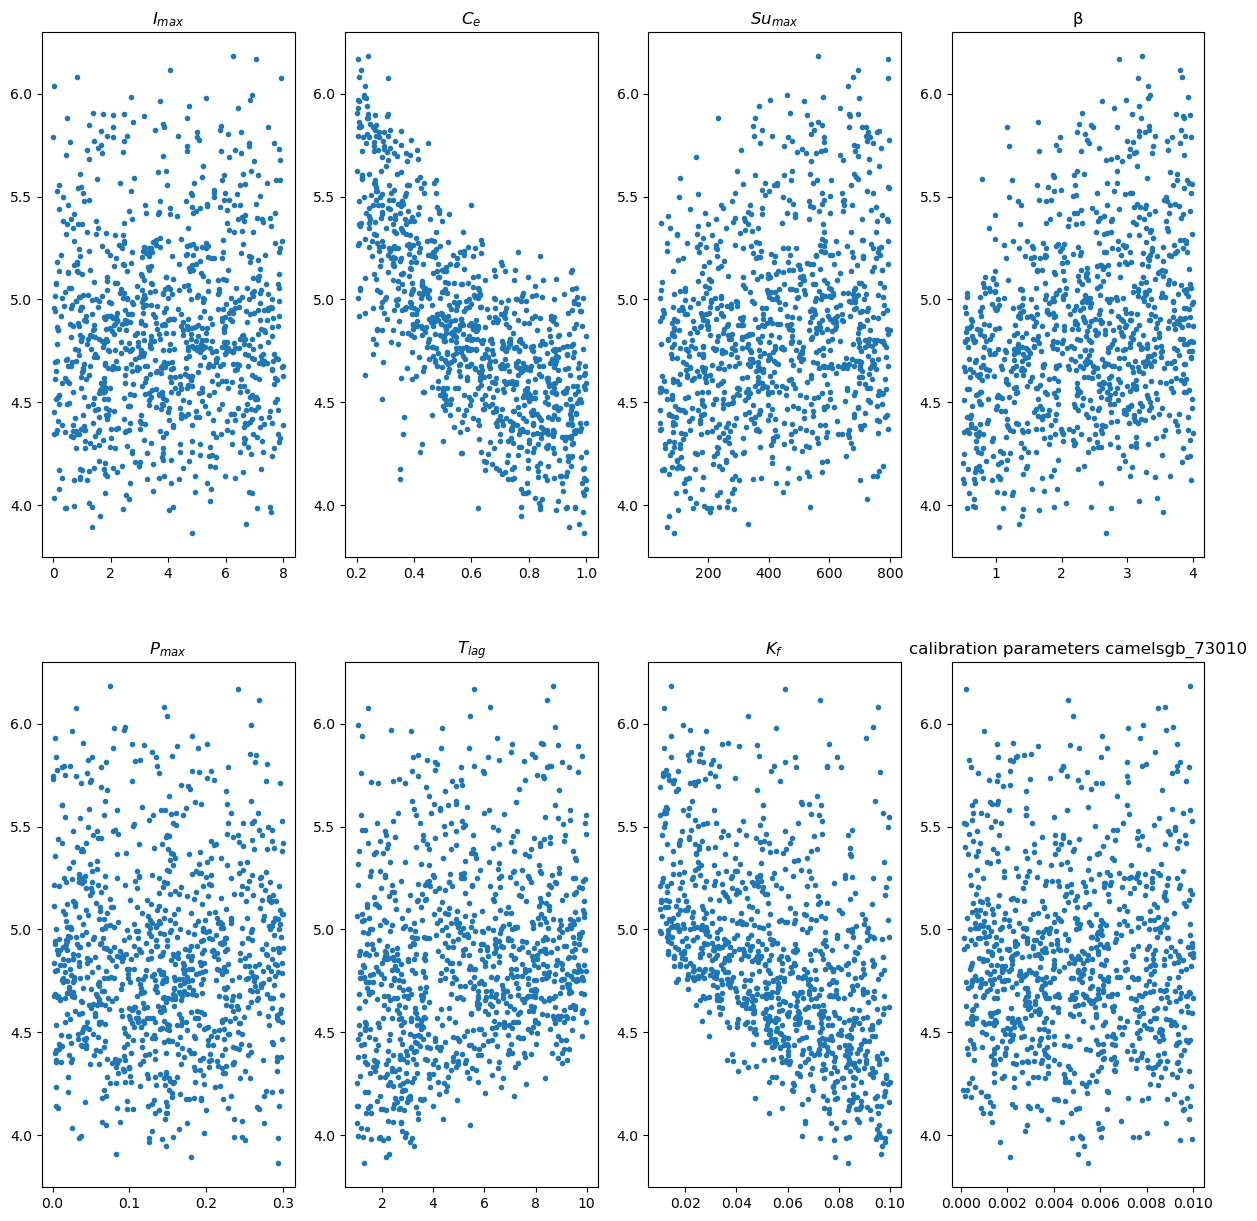

In [17]:
xFigNr = 2
yFigNr = 4



ensemble = []

for counter in range(N):

    #create random parameter for this ensemble member
    
    ensemble.append(ewatercycle.models.HBVLocal(forcing=ERA5_forcing))
    config_file, _ = ensemble[counter].setup(
                            parameters = ','.join([str(p) for p in parameters[:,counter]]),
                            initial_storage=','.join([str(s) for s in s_0]),
                            cfg_dir = "/home/rhut/configFiles/" + camelsgb_id + "_hbv_ensembleMember_" + str(counter),
                               )
    ensemble[counter].initialize(config_file)

#an object to show a progress bar, since this can take a while:
f = IntProgress(min=0, max=N) # instantiate the bar
display(f) # display the bar


#an empty array to store the results in
objectives = []

#loop over all ensemble members
for ensembleMember in ensemble:
    Q_m = []
    time = []
    while ensembleMember.time < ensembleMember.end_time:
        ensembleMember.update()
        discharge_this_timestep = ensembleMember.get_value("Q") #* Caravan_observations_area[caravan_basin_id] / (1000 * 86400)
        Q_m.append(discharge_this_timestep[0])
        time.append(pd.Timestamp(ensembleMember.time_as_datetime.date()))
    
    #calculate the objective function 
    discharge_dataframe = pd.DataFrame({'model output': Q_m}, index=pd.to_datetime(time))
    objective_this_model = calibrationObjective(discharge_dataframe,caravan_observation_df,calibration_start_date,calibration_end_date)
    objectives.append(objective_this_model)

    #it is good practice to remove any variable you don't need anymore to save memory.
    del Q_m, time, discharge_dataframe, objective_this_model

    #update progress bar
    f.value += 1

    ensembleMember.finalize()


fig, axs = plt.subplots(xFigNr, yFigNr,figsize = (15,15))

for xFig in range(xFigNr):
    for yFig in range(yFigNr):
        paramCounter = xFig*yFigNr + yFig
        axs[xFig,yFig].plot(parameters[paramCounter,:],objectives,'.')
        axs[xFig,yFig].set_title(p_names[paramCounter])
plt.title('calibration parameters ' + camelsgb_id)
plt.savefig('/home/rhut/figures/calibration parameters ' + camelsgb_id + '.png')

parameters_minimum_index = np.argmin(np.array(objectives))
parameters_minimum = parameters[:,parameters_minimum_index]
np.savetxt("/home/rhut/configFiles/calibration" + camelsgb_id + ".csv", parameters_minimum, delimiter=",")
print(parameters_minimum)

